In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import models, layers  
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D,Input
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121


C:\Users\ajay\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [3]:
import os

# Define the root directory containing classes (folders)
root_dir = 'Plant_leave_diseases_dataset_without_augmentation'

# Get the list of classes (folders) in the root directory
classes = [class_name for class_name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, class_name))]

# Print the list of classes
print('Classes:', classes)

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tom

In [4]:
# Print the number of classes
num_classes = len(classes)
print('Number of classes:', num_classes)

Number of classes: 39


In [6]:
# Count the number of images in each class
class_counts = {cls: len(os.listdir(os.path.join(dir_path, cls))) for cls in classes}
print("Class counts:", class_counts)

Class counts: {'Apple___Apple_scab': 630, 'Apple___Black_rot': 621, 'Apple___Cedar_apple_rust': 275, 'Apple___healthy': 1645, 'Background_without_leaves': 1143, 'Blueberry___healthy': 1502, 'Cherry___healthy': 854, 'Cherry___Powdery_mildew': 1052, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Corn___Common_rust': 1192, 'Corn___healthy': 1162, 'Corn___Northern_Leaf_Blight': 985, 'Grape___Black_rot': 1180, 'Grape___Esca_(Black_Measles)': 1383, 'Grape___healthy': 423, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Peach___Bacterial_spot': 2297, 'Peach___healthy': 360, 'Pepper,_bell___Bacterial_spot': 997, 'Pepper,_bell___healthy': 1478, 'Potato___Early_blight': 1000, 'Potato___healthy': 152, 'Potato___Late_blight': 1000, 'Raspberry___healthy': 371, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Strawberry___healthy': 456, 'Strawberry___Leaf_scorch': 1109, 'Tomato___Bacterial_spot': 2127, 'Tomato___Early_blight': 1

## This will create a bar plot to visualize the class distribution.

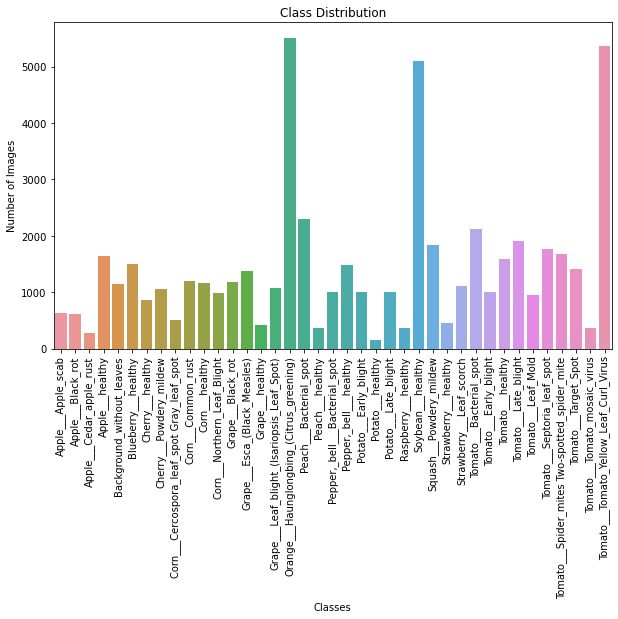

In [7]:
# Visualize the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

## This will display a sample image from each class.

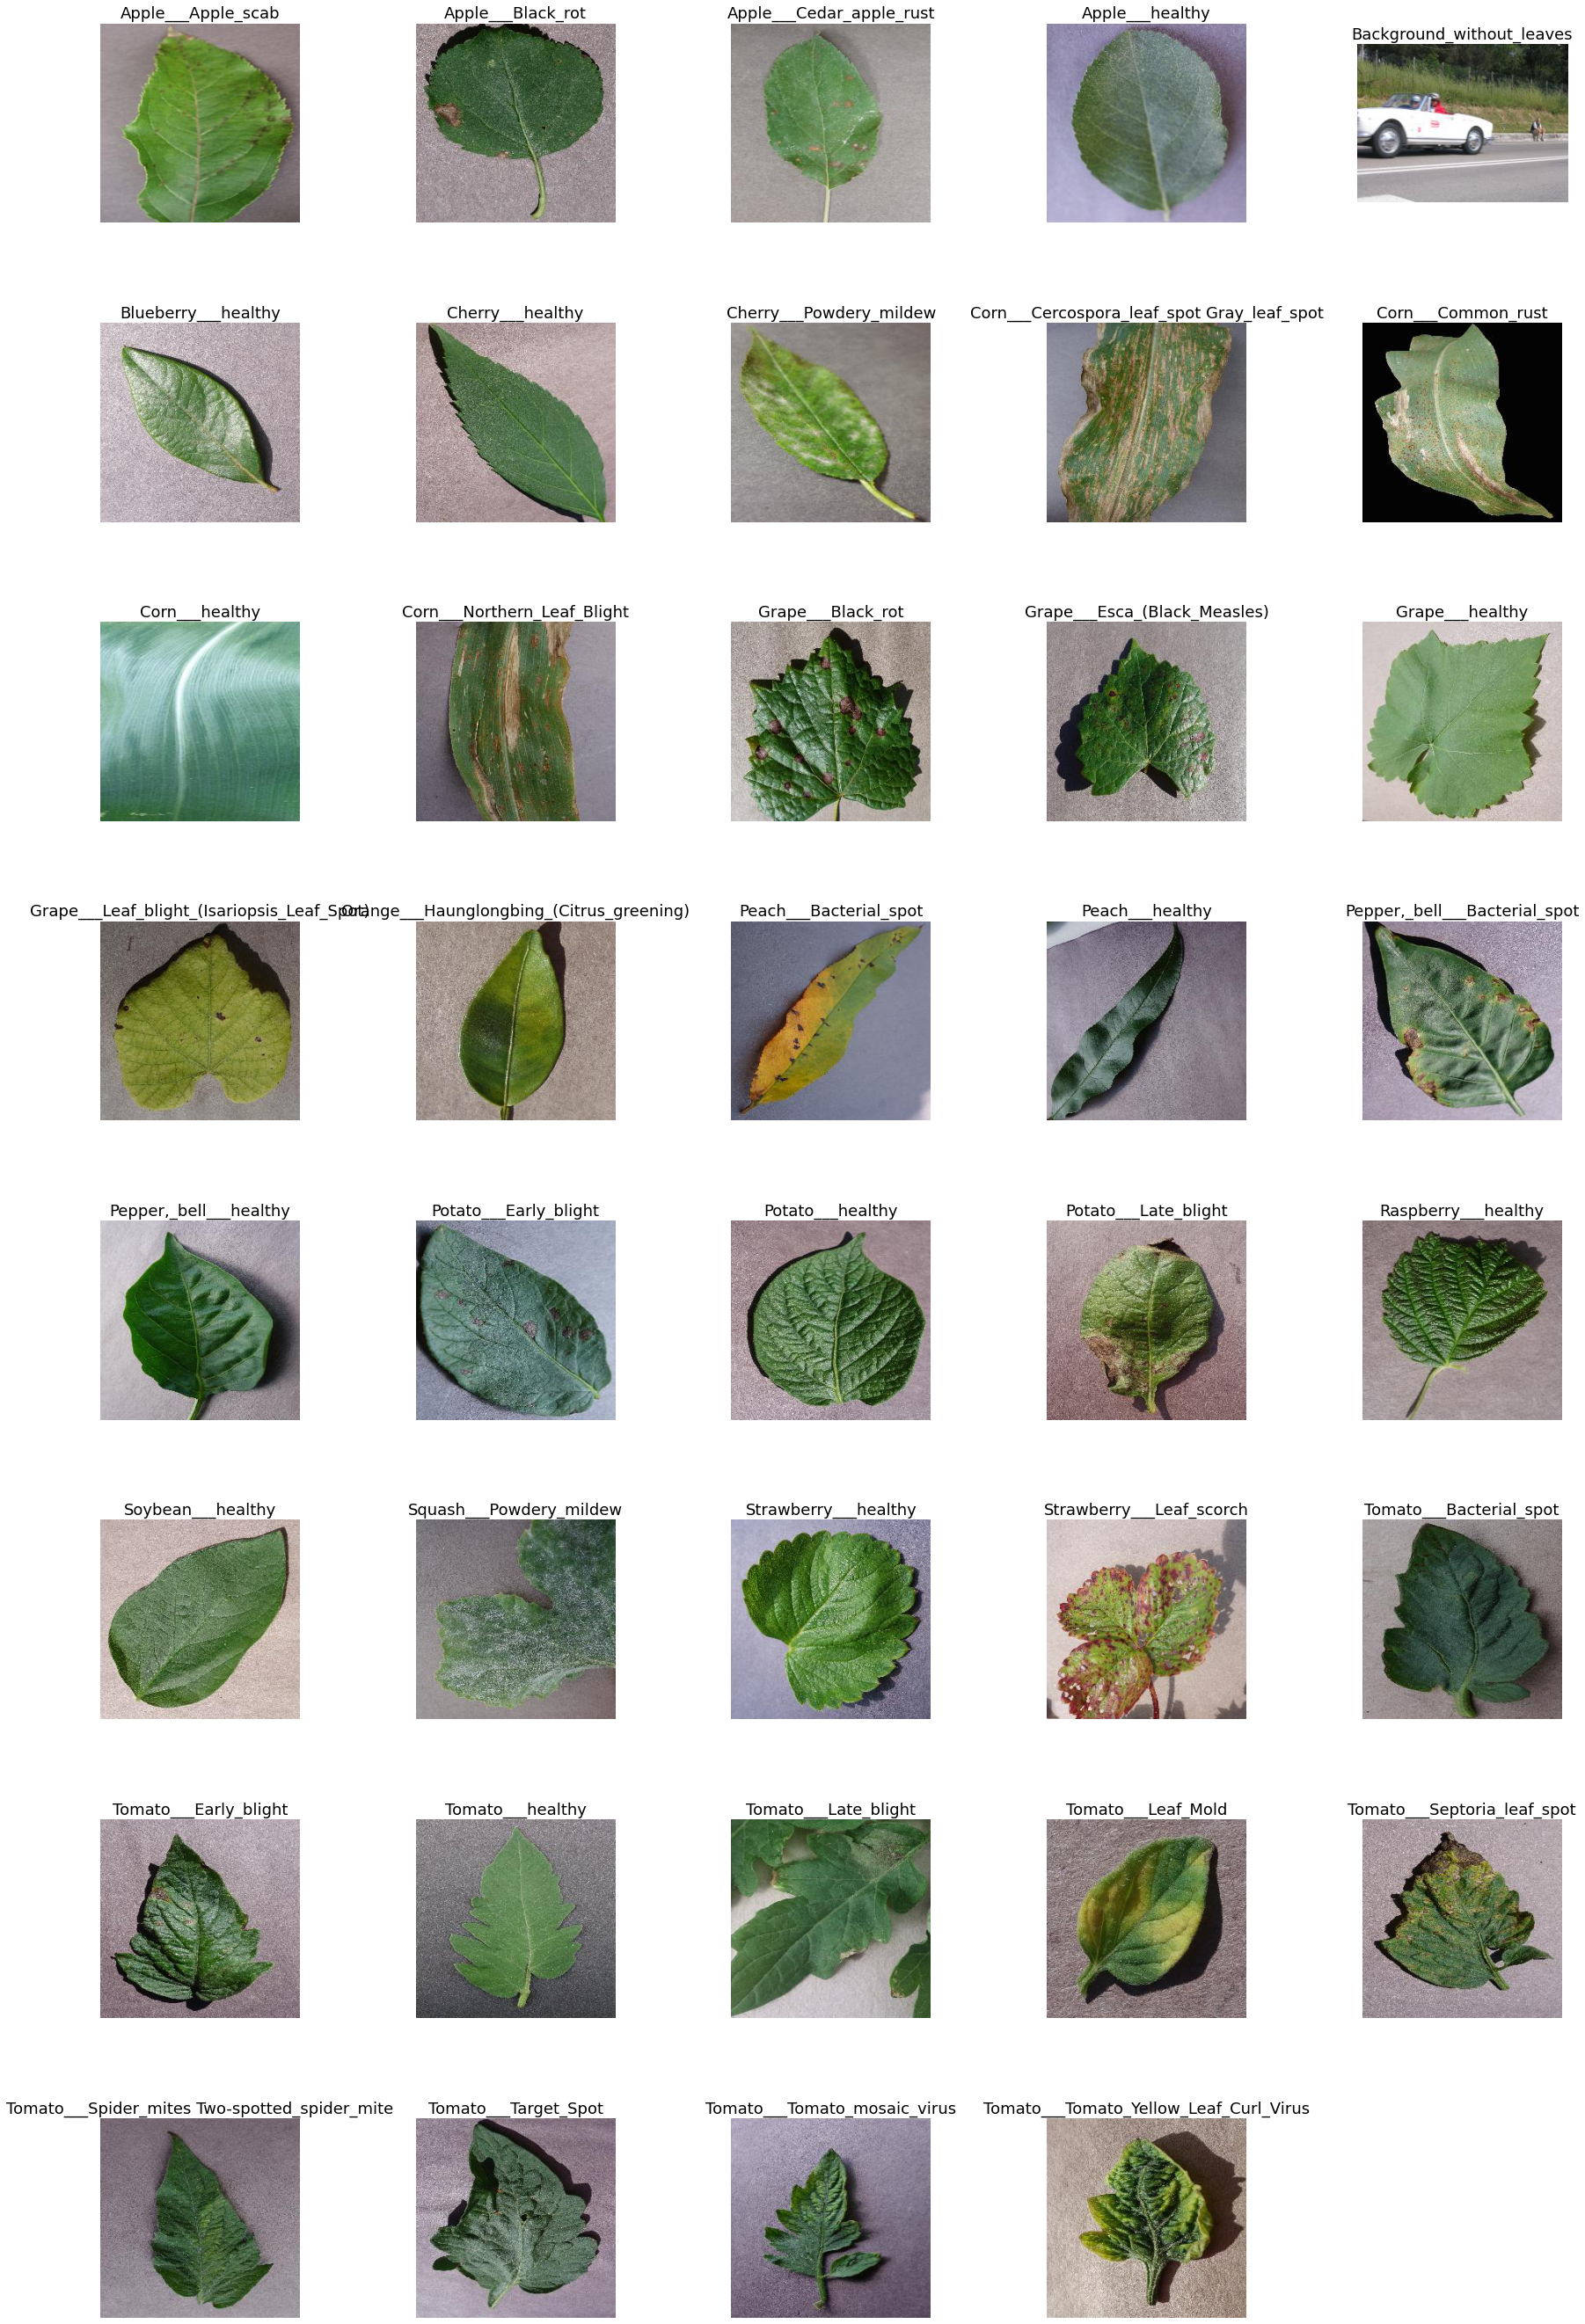

In [8]:
# Display a sample image from each class
num_cols = min(len(classes), 5)  # Set the number of columns to 5 or the number of classes, whichever is smaller
num_rows = (len(classes) + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 6 * num_rows))  # Adjust figure size based on the number of rows

for idx, cls in enumerate(classes):
    row = idx // num_cols  # Calculate the row index
    col = idx % num_cols  # Calculate the column index
    img_path = os.path.join(dir_path, cls, os.listdir(os.path.join(dir_path, cls))[0])
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(cls, fontsize=18)
    axes[row, col].axis('off')

# Turn off axis for unused subplots
num_unused_subplots = num_rows * num_cols - len(classes)
if num_unused_subplots > 0:
    for idx in range(num_unused_subplots):
        row = (len(classes) + idx) // num_cols
        col = (len(classes) + idx) % num_cols
        axes[row, col].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust horizontal and vertical spacing

# Increase font size for axis labels
plt.rcParams.update({'font.size': 16})

plt.show()

## Image Pixel Analysis

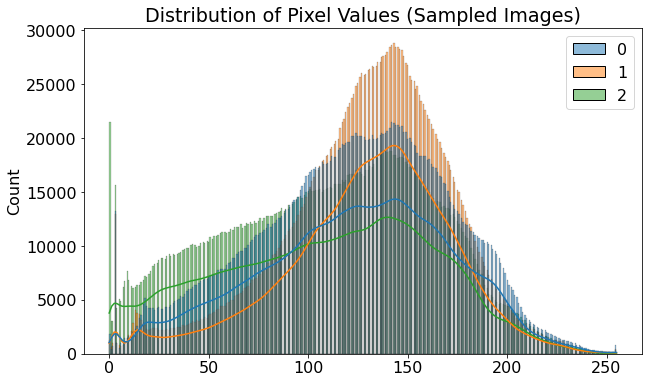

In [10]:
# Get the pixel values of sampled images
num_samples_per_class = 1  # Set the number of images to sample from each class
all_pixels = []

for cls in classes:
    class_dir = os.path.join(dir_path, cls)
    class_images = [Image.open(os.path.join(class_dir, img_path)) for img_path in np.random.choice(os.listdir(class_dir), num_samples_per_class, replace=False)]
    for img in class_images:
        all_pixels.extend(list(img.getdata()))

# Convert pixel values to numpy array
all_pixels = np.array(all_pixels)

# Plot the distribution of pixel values
plt.figure(figsize=(10, 6))
sns.histplot(all_pixels, kde=True)  # Use histplot instead of distplot
plt.title('Distribution of Pixel Values (Sampled Images)')
plt.show()

## Image Color Analysis

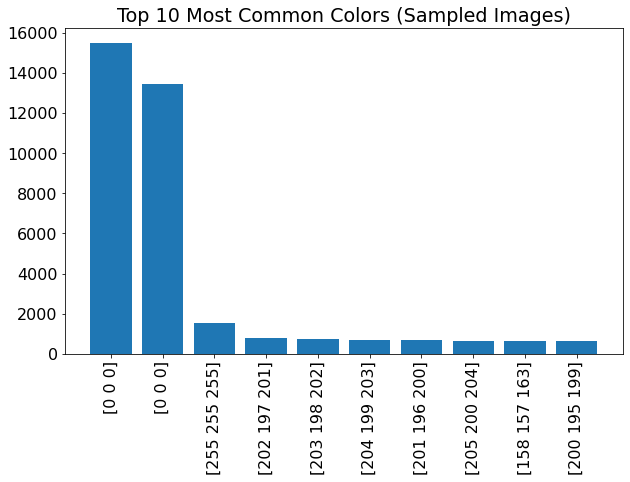

In [9]:
# Get the color distribution of sampled images
num_samples_per_class = 2
all_colors = []
for cls in classes:
    class_dir = os.path.join(dir_path, cls)
    class_images = [Image.open(os.path.join(class_dir, img_path)) for img_path in np.random.choice(os.listdir(class_dir), num_samples_per_class, replace=False)]
    for img in class_images:
        colors, counts = np.unique(img.getdata(), axis=0, return_counts=True)
        all_colors.extend(list(zip(colors, counts)))

# Convert colors and counts to numpy arrays
colors, counts = zip(*all_colors)
colors = np.array(colors)
counts = np.array(counts)

# Plot the top 10 most common colors
top_colors = colors[np.argsort(-counts)[:10]]
top_counts = counts[np.argsort(-counts)[:10]]

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_colors)), top_counts, align='center')
plt.xticks(range(len(top_colors)), [str(color) for color in top_colors], rotation=90)
plt.title('Top 10 Most Common Colors (Sampled Images)')
plt.show()

## Class-wise Image Analysis

Class: Apple___Apple_scab, Average Image Size: (256.00, 256.00)
Class: Apple___Apple_scab, Average Pixel Value: 103.19


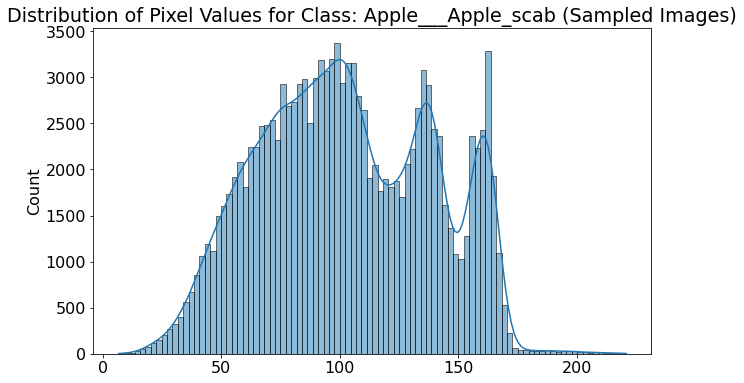

Class: Apple___Black_rot, Average Image Size: (256.00, 256.00)
Class: Apple___Black_rot, Average Pixel Value: 115.67


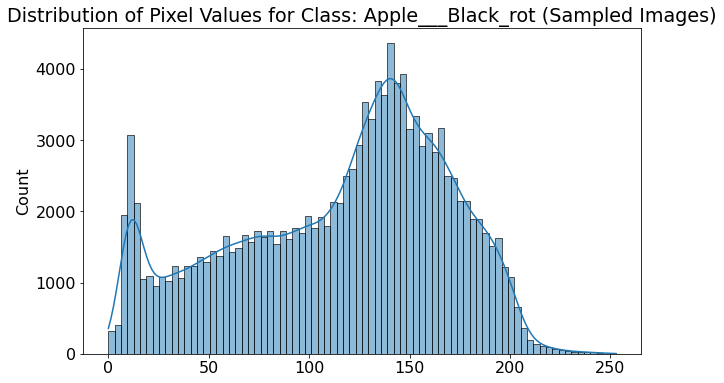

Class: Apple___Cedar_apple_rust, Average Image Size: (256.00, 256.00)
Class: Apple___Cedar_apple_rust, Average Pixel Value: 124.54


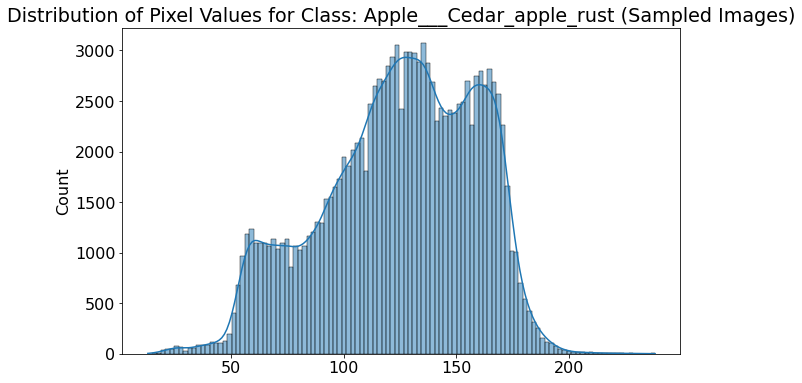

Class: Apple___healthy, Average Image Size: (256.00, 256.00)
Class: Apple___healthy, Average Pixel Value: 128.18


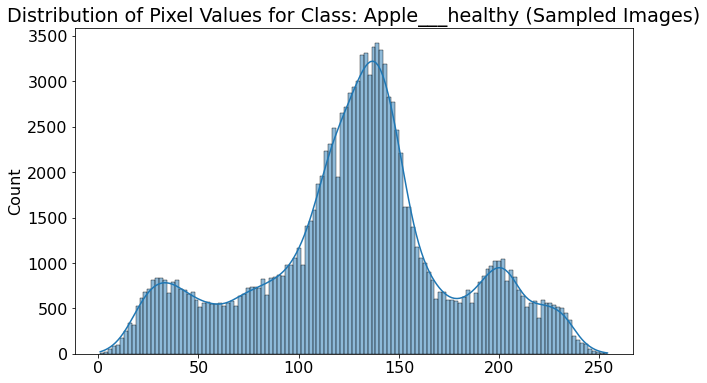

Class: Background_without_leaves, Average Image Size: (256.00, 192.00)
Class: Background_without_leaves, Average Pixel Value: 94.88


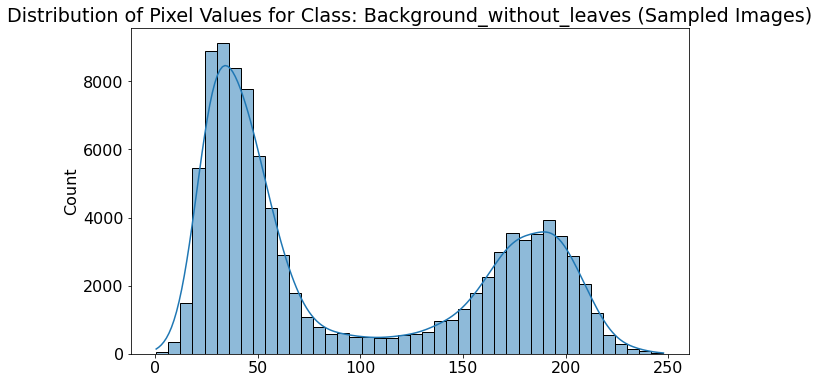

Class: Blueberry___healthy, Average Image Size: (256.00, 256.00)
Class: Blueberry___healthy, Average Pixel Value: 134.88


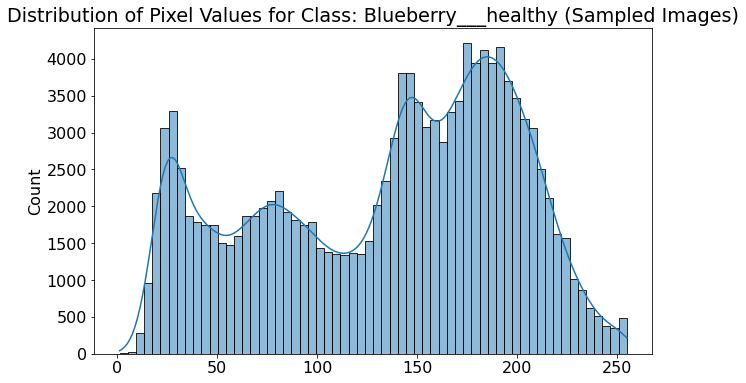

Class: Cherry___healthy, Average Image Size: (256.00, 256.00)
Class: Cherry___healthy, Average Pixel Value: 173.30


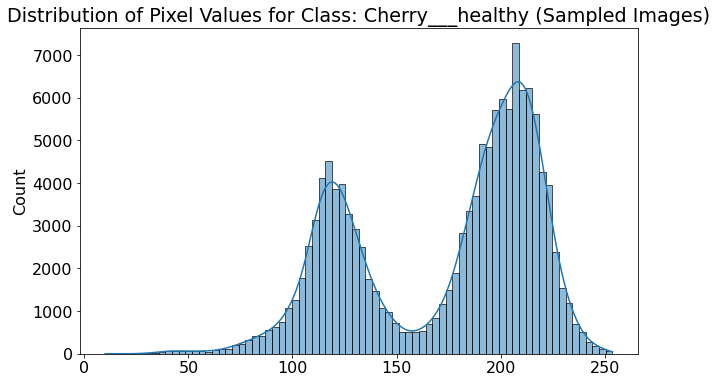

Class: Cherry___Powdery_mildew, Average Image Size: (256.00, 256.00)
Class: Cherry___Powdery_mildew, Average Pixel Value: 115.25


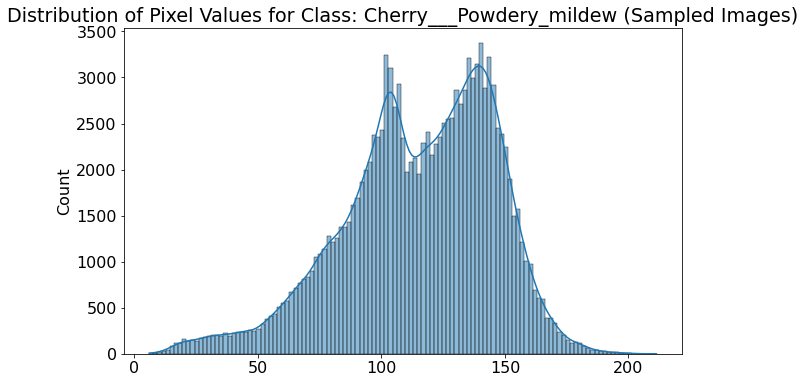

Class: Corn___Cercospora_leaf_spot Gray_leaf_spot, Average Image Size: (256.00, 256.00)
Class: Corn___Cercospora_leaf_spot Gray_leaf_spot, Average Pixel Value: 116.43


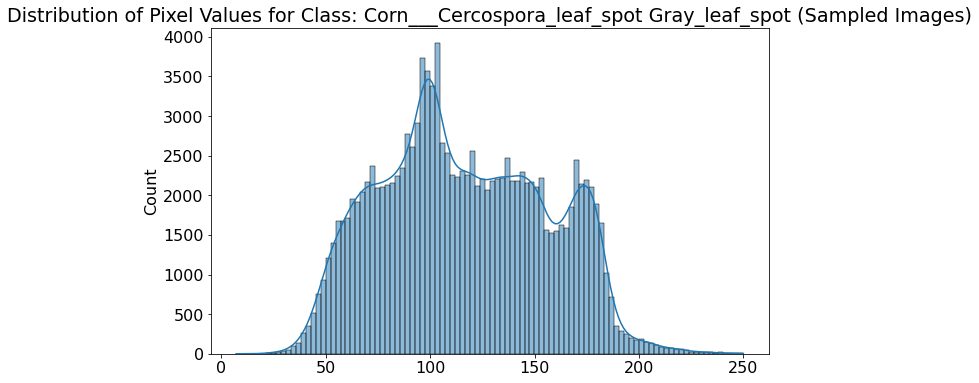

Class: Corn___Common_rust, Average Image Size: (256.00, 256.00)
Class: Corn___Common_rust, Average Pixel Value: 93.20


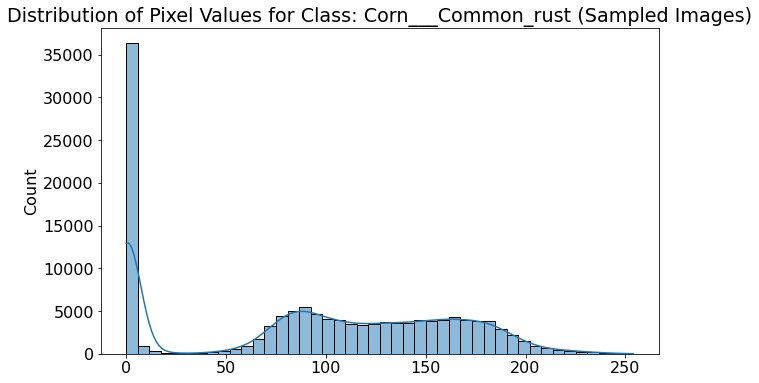

Class: Corn___healthy, Average Image Size: (256.00, 256.00)
Class: Corn___healthy, Average Pixel Value: 157.01


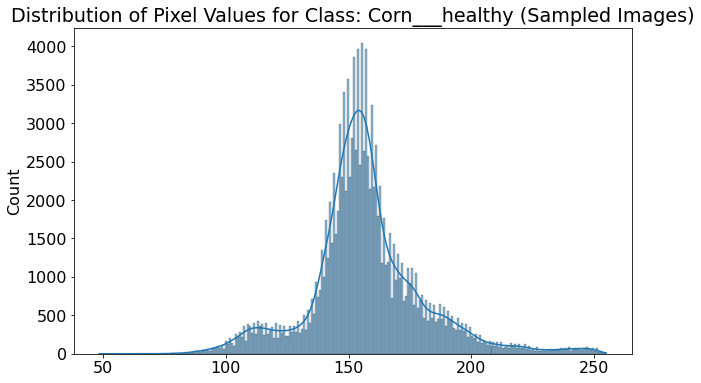

Class: Corn___Northern_Leaf_Blight, Average Image Size: (256.00, 256.00)
Class: Corn___Northern_Leaf_Blight, Average Pixel Value: 105.16


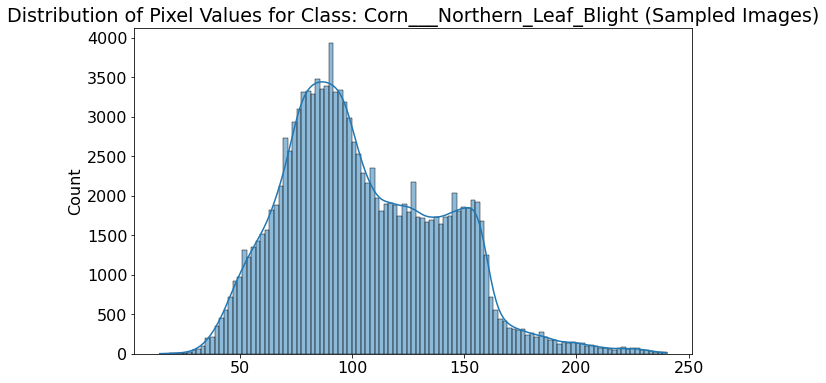

Class: Grape___Black_rot, Average Image Size: (256.00, 256.00)
Class: Grape___Black_rot, Average Pixel Value: 125.56


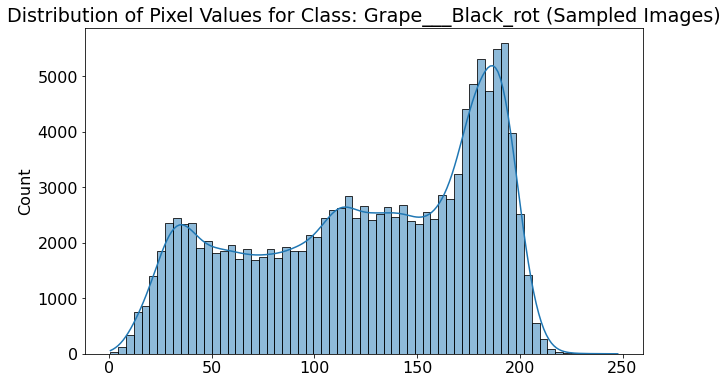

Class: Grape___Esca_(Black_Measles), Average Image Size: (256.00, 256.00)
Class: Grape___Esca_(Black_Measles), Average Pixel Value: 132.16


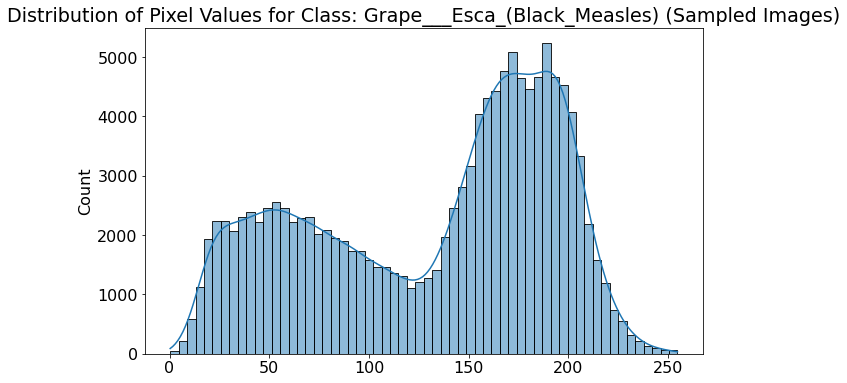

Class: Grape___healthy, Average Image Size: (256.00, 256.00)
Class: Grape___healthy, Average Pixel Value: 131.75


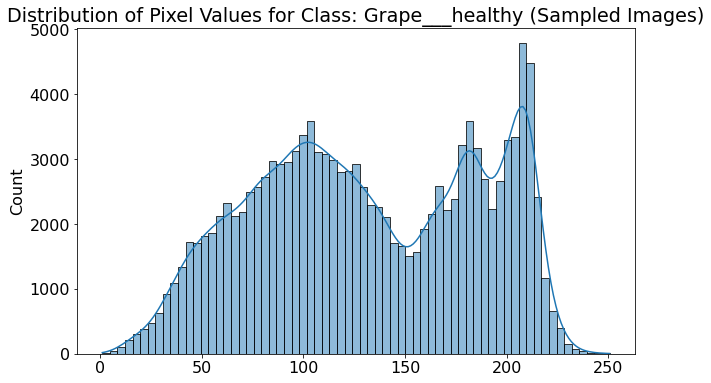

Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Average Image Size: (256.00, 256.00)
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Average Pixel Value: 113.57


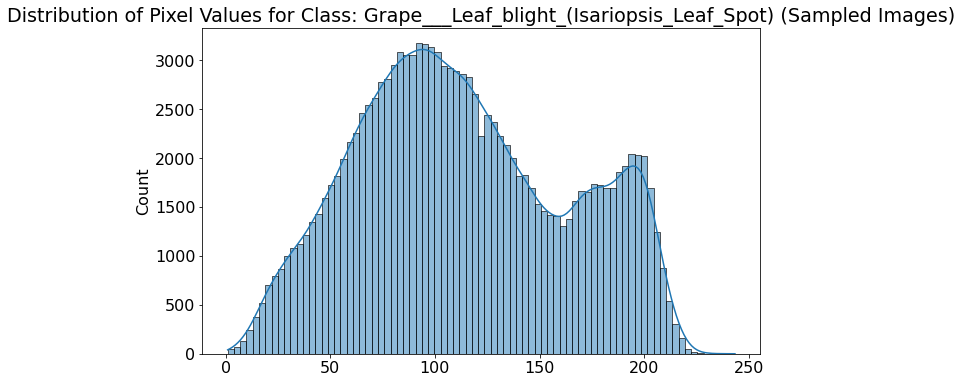

Class: Orange___Haunglongbing_(Citrus_greening), Average Image Size: (256.00, 256.00)
Class: Orange___Haunglongbing_(Citrus_greening), Average Pixel Value: 100.54


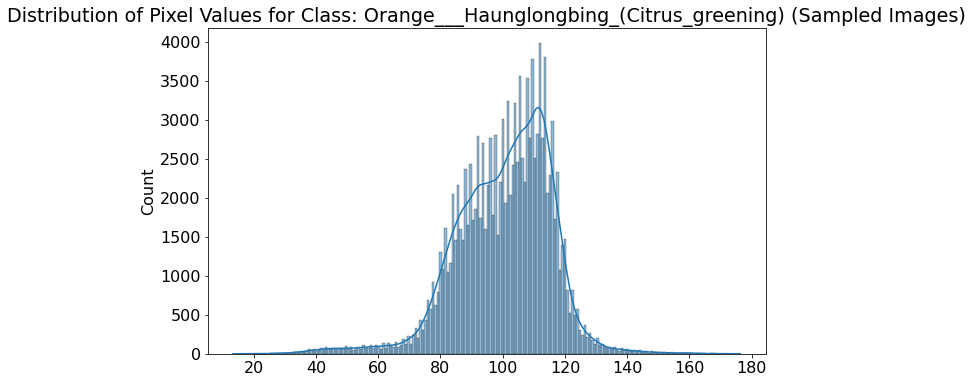

Class: Peach___Bacterial_spot, Average Image Size: (256.00, 256.00)
Class: Peach___Bacterial_spot, Average Pixel Value: 111.29


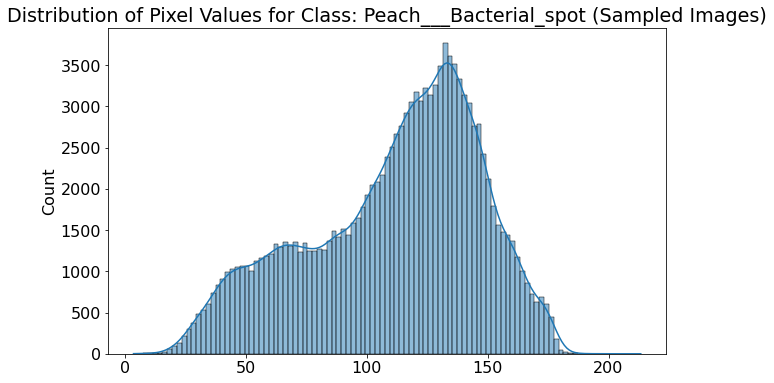

Class: Peach___healthy, Average Image Size: (256.00, 256.00)
Class: Peach___healthy, Average Pixel Value: 127.53


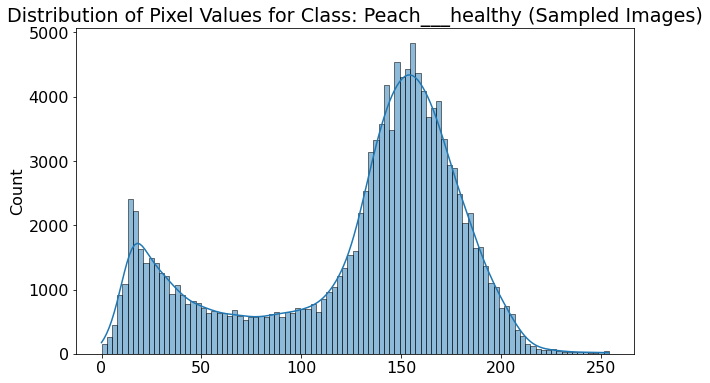

Class: Pepper,_bell___Bacterial_spot, Average Image Size: (256.00, 256.00)
Class: Pepper,_bell___Bacterial_spot, Average Pixel Value: 113.97


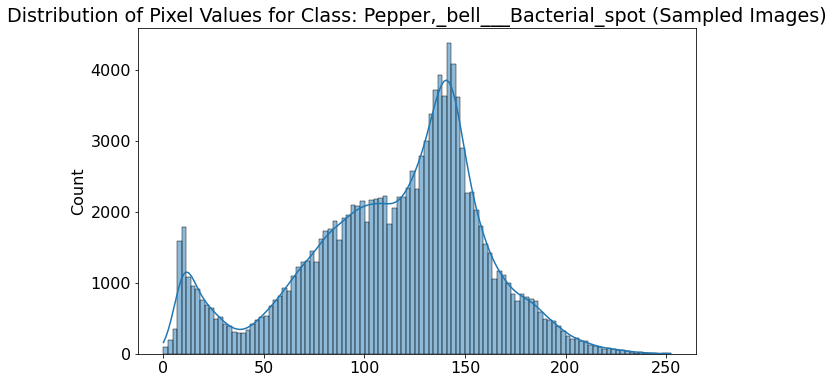

Class: Pepper,_bell___healthy, Average Image Size: (256.00, 256.00)
Class: Pepper,_bell___healthy, Average Pixel Value: 117.58


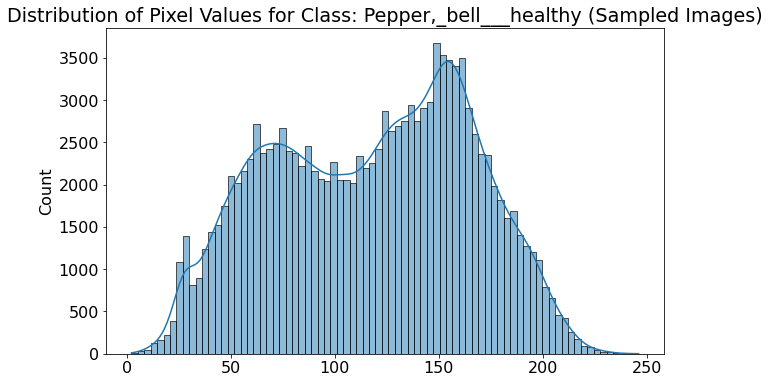

Class: Potato___Early_blight, Average Image Size: (256.00, 256.00)
Class: Potato___Early_blight, Average Pixel Value: 127.64


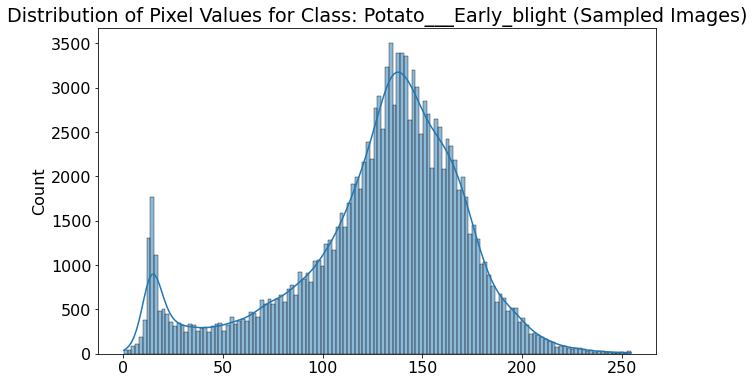

Class: Potato___healthy, Average Image Size: (256.00, 256.00)
Class: Potato___healthy, Average Pixel Value: 116.75


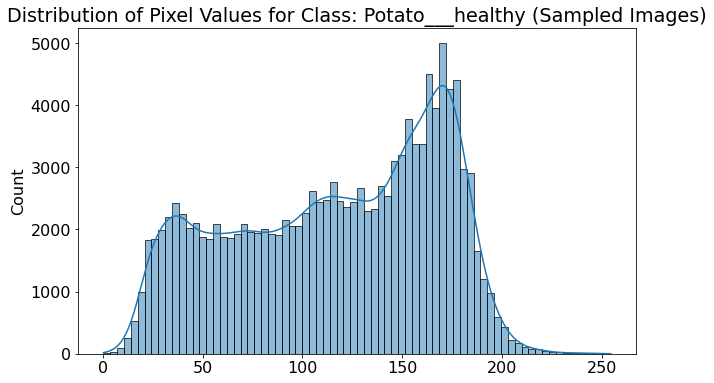

Class: Potato___Late_blight, Average Image Size: (256.00, 256.00)
Class: Potato___Late_blight, Average Pixel Value: 110.76


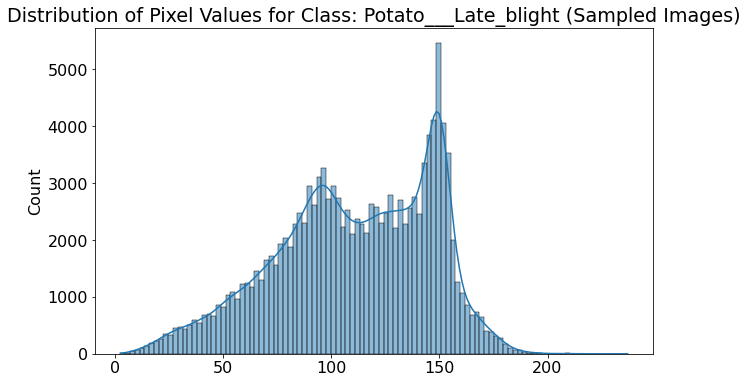

Class: Raspberry___healthy, Average Image Size: (256.00, 256.00)
Class: Raspberry___healthy, Average Pixel Value: 141.12


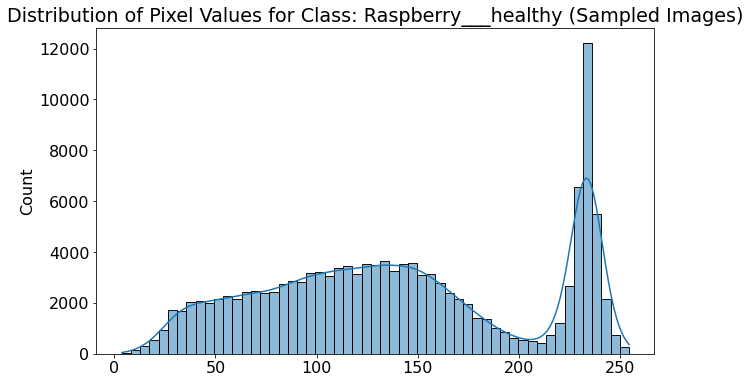

Class: Soybean___healthy, Average Image Size: (256.00, 256.00)
Class: Soybean___healthy, Average Pixel Value: 143.00


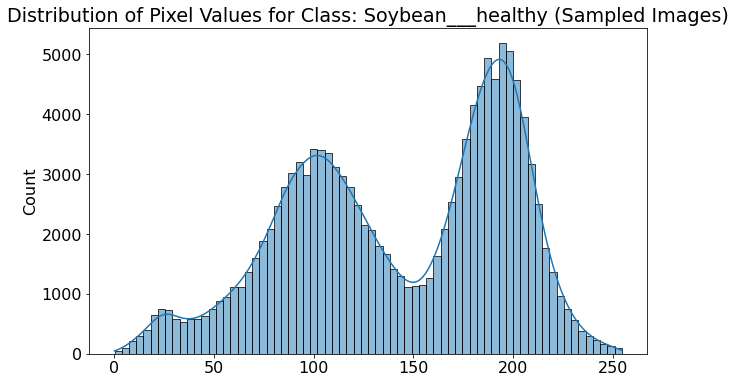

Class: Squash___Powdery_mildew, Average Image Size: (256.00, 256.00)
Class: Squash___Powdery_mildew, Average Pixel Value: 122.67


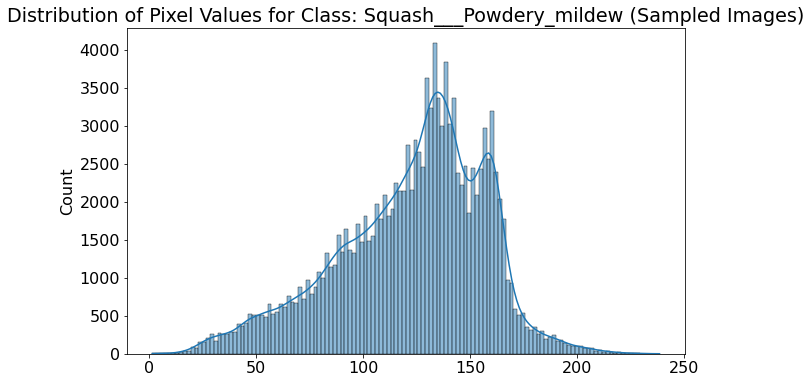

Class: Strawberry___healthy, Average Image Size: (256.00, 256.00)
Class: Strawberry___healthy, Average Pixel Value: 130.49


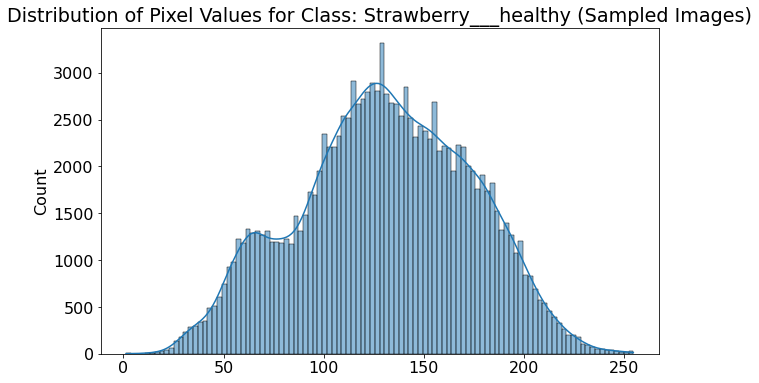

Class: Strawberry___Leaf_scorch, Average Image Size: (256.00, 256.00)
Class: Strawberry___Leaf_scorch, Average Pixel Value: 137.05


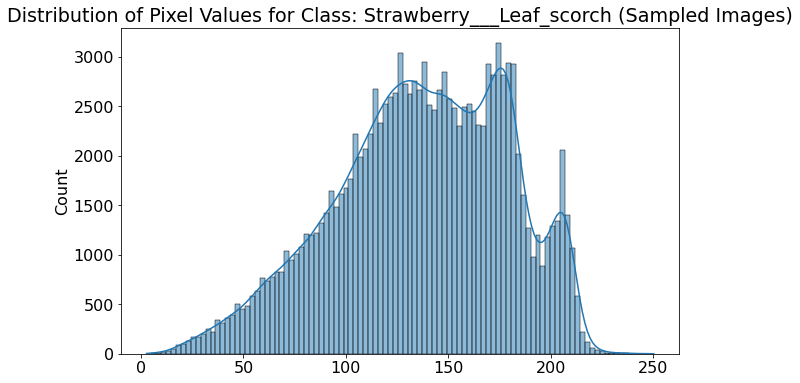

Class: Tomato___Bacterial_spot, Average Image Size: (256.00, 256.00)
Class: Tomato___Bacterial_spot, Average Pixel Value: 102.99


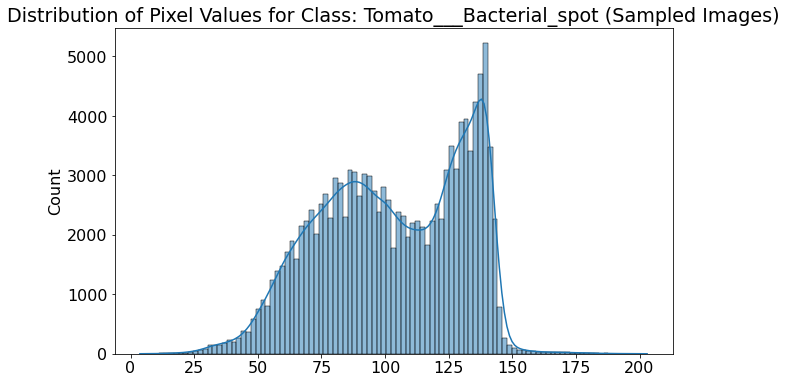

Class: Tomato___Early_blight, Average Image Size: (256.00, 256.00)
Class: Tomato___Early_blight, Average Pixel Value: 92.01


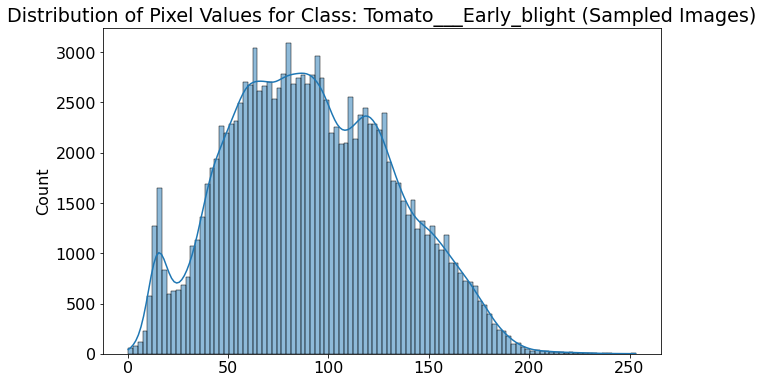

Class: Tomato___healthy, Average Image Size: (256.00, 256.00)
Class: Tomato___healthy, Average Pixel Value: 117.95


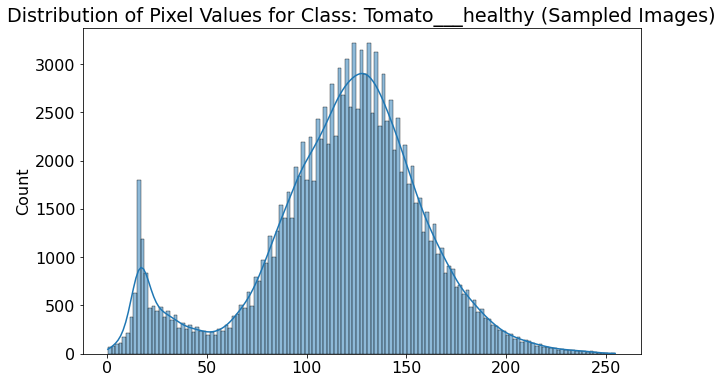

Class: Tomato___Late_blight, Average Image Size: (256.00, 256.00)
Class: Tomato___Late_blight, Average Pixel Value: 134.67


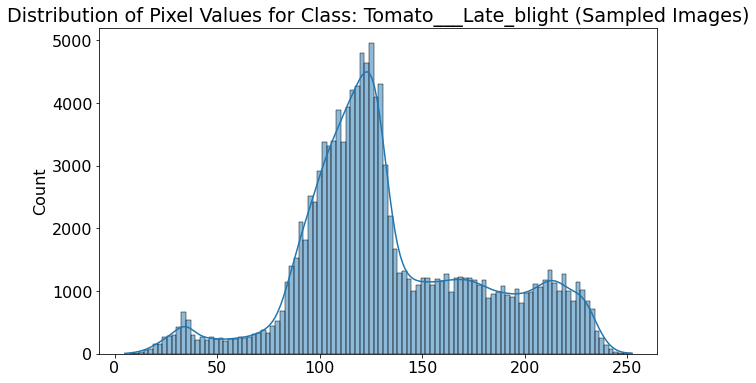

Class: Tomato___Leaf_Mold, Average Image Size: (256.00, 256.00)
Class: Tomato___Leaf_Mold, Average Pixel Value: 109.43


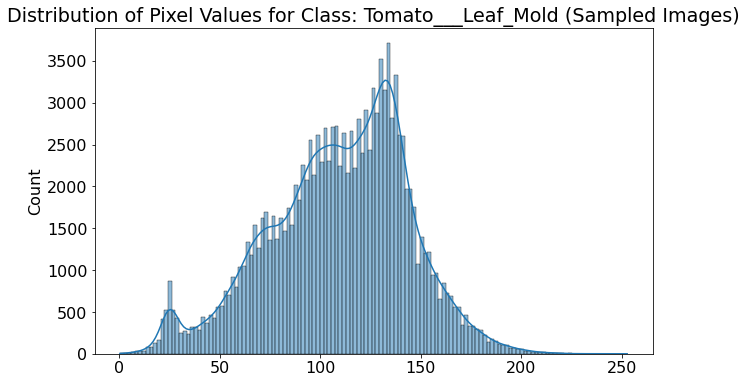

Class: Tomato___Septoria_leaf_spot, Average Image Size: (256.00, 256.00)
Class: Tomato___Septoria_leaf_spot, Average Pixel Value: 117.06


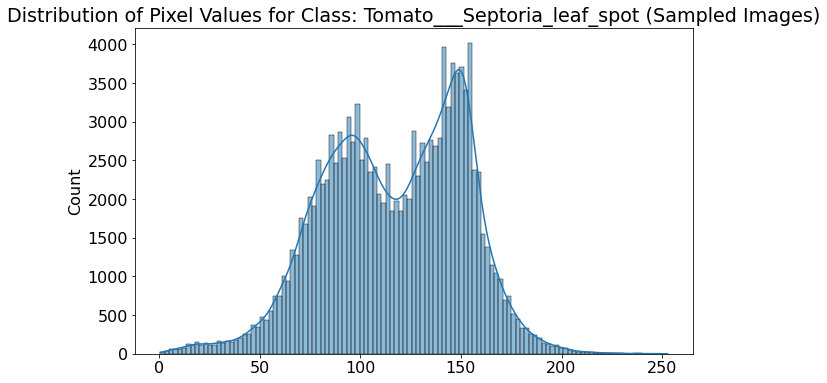

Class: Tomato___Spider_mites Two-spotted_spider_mite, Average Image Size: (256.00, 256.00)
Class: Tomato___Spider_mites Two-spotted_spider_mite, Average Pixel Value: 121.62


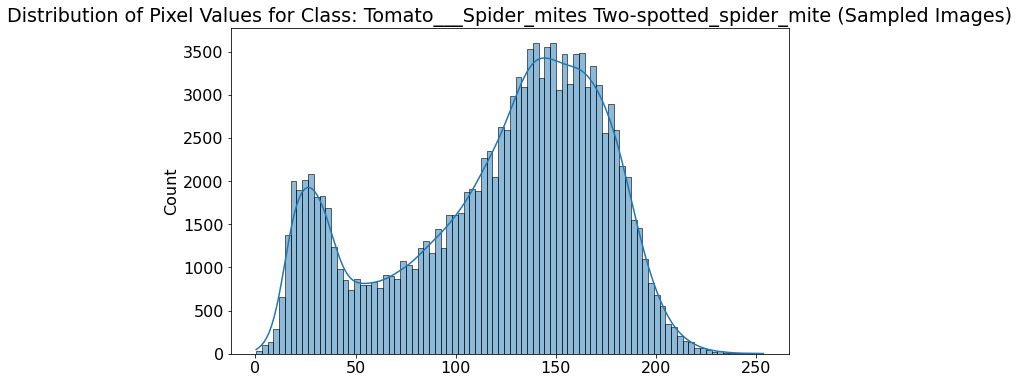

Class: Tomato___Target_Spot, Average Image Size: (256.00, 256.00)
Class: Tomato___Target_Spot, Average Pixel Value: 115.42


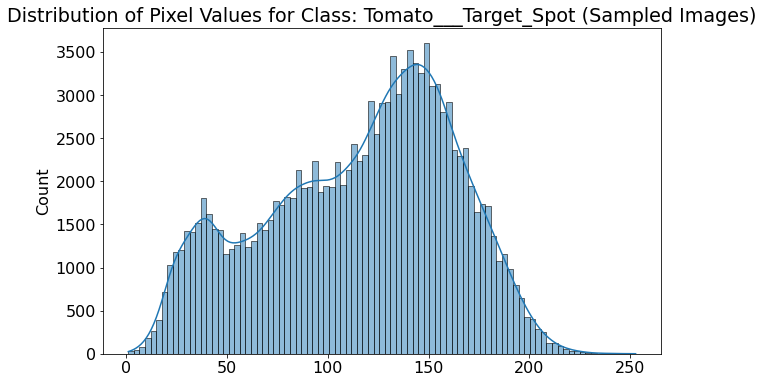

Class: Tomato___Tomato_mosaic_virus, Average Image Size: (256.00, 256.00)
Class: Tomato___Tomato_mosaic_virus, Average Pixel Value: 128.64


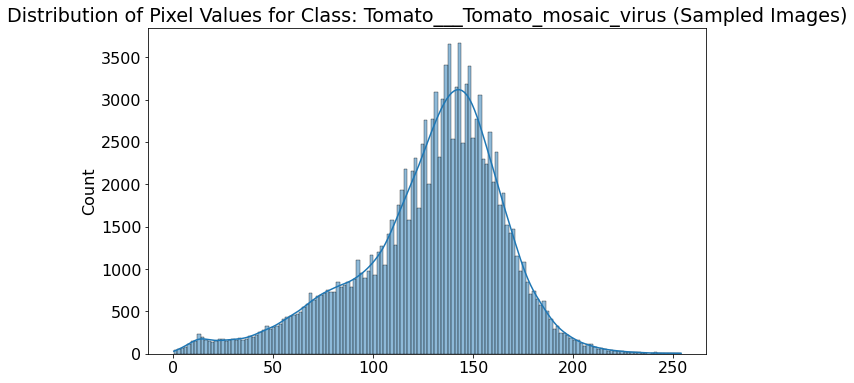

Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Average Image Size: (256.00, 256.00)
Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Average Pixel Value: 115.19


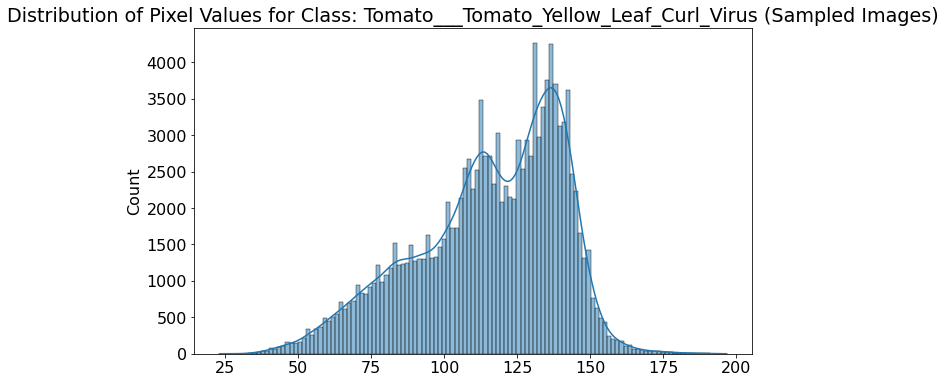

In [11]:
# Analyze sampled images for each class
for cls in classes:
    class_dir = os.path.join(dir_path, cls)
    class_images = [Image.open(os.path.join(class_dir, img_path)) for img_path in np.random.choice(os.listdir(class_dir), num_samples_per_class, replace=False)]

    # Calculate average image size
    sizes = [img.size for img in class_images]
    avg_width = sum(size[0] for size in sizes) / len(sizes)
    avg_height = sum(size[1] for size in sizes) / len(sizes)
    print(f"Class: {cls}, Average Image Size: ({avg_width:.2f}, {avg_height:.2f})")

    # Calculate average pixel value
    all_pixels = []
    for img in class_images:
        pixels = list(img.getdata())
        avg_pixel_values = [(sum(pixel) / 3) for pixel in pixels]  # Calculate average of RGB values
        all_pixels.extend(avg_pixel_values)

    avg_pixel = sum(all_pixels) / len(all_pixels)
    print(f"Class: {cls}, Average Pixel Value: {avg_pixel:.2f}")

    # Plot the distribution of pixel values for the sampled images
    plt.figure(figsize=(10, 6))
    sns.histplot(all_pixels, kde=True)  # Use histplot instead of distplot
    plt.title(f'Distribution of Pixel Values for Class: {cls} (Sampled Images)')
    plt.show()

In [5]:
# Dataset Path
base_dir = 'Plant_leave_diseases_dataset_without_augmentation'

(256, 256, 3)


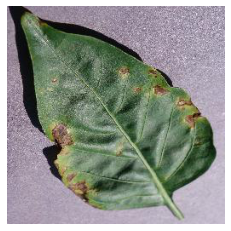

In [8]:
import matplotlib.image as mpimg
image_path = r"C:\Users\ajay\OneDrive\Desktop\capstone\Plant_leave_diseases_dataset_without_augmentation\Pepper,_bell___Bacterial_spot\image (1).JPG"

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [9]:
image_path = r"C:\Users\ajay\OneDrive\Desktop\capstone\Plant_leave_diseases_dataset_without_augmentation\Pepper,_bell___Bacterial_spot\image (1).JPG"

# Read the image
img = mpimg.imread(image_path)

print(img)
     

[[[155 140 159]
  [120 106 123]
  [ 31  18  35]
  ...
  [159 150 169]
  [148 139 158]
  [149 140 159]]

 [[147 132 151]
  [126 112 129]
  [ 45  32  49]
  ...
  [154 145 164]
  [169 160 179]
  [154 145 164]]

 [[152 137 156]
  [151 137 154]
  [ 80  67  84]
  ...
  [130 121 140]
  [166 157 176]
  [167 158 177]]

 ...

 [[164 151 171]
  [159 146 166]
  [157 144 164]
  ...
  [201 192 209]
  [201 192 209]
  [200 191 208]]

 [[162 149 169]
  [159 146 166]
  [162 149 169]
  ...
  [200 191 208]
  [199 190 207]
  [198 189 206]]

 [[174 161 181]
  [166 153 173]
  [161 148 168]
  ...
  [198 189 206]
  [196 187 204]
  [195 186 203]]]


In [10]:
# Image Parameters
img_size = 224
batch_size = 32

In [11]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [12]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 44371 images belonging to 39 classes.


In [13]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 11077 images belonging to 39 classes.


In [16]:
# Model Definition
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

C:\Users\ajay\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [17]:
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      47,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 39)                  │          10,023 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,805,415 (182.36 MB)

 Trainable params: 47,805,415 (182.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Training the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=5,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/5


C:\Users\ajay\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1227s 884ms/step - accuracy: 0.6090 - loss: 1.6291 - val_accuracy: 0.8582 - val_loss: 0.4619
Epoch 2/5
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1s 62us/step - accuracy: 0.9062 - loss: 0.1209 - val_accuracy: 0.8000 - val_loss: 0.2339
Epoch 3/5


C:\Users\ajay\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1255s 906ms/step - accuracy: 0.9211 - loss: 0.2516 - val_accuracy: 0.8699 - val_loss: 0.4289
Epoch 4/5
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1s 109us/step - accuracy: 0.9062 - loss: 0.1526 - val_accuracy: 0.8000 - val_loss: 0.2230
Epoch 5/5
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1295s 934ms/step - accuracy: 0.9658 - loss: 0.1059 - val_accuracy: 0.8701 - val_loss: 0.4844


In [20]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
346/346 ━━━━━━━━━━━━━━━━━━━━ 56s 163ms/step - accuracy: 0.8742 - loss: 0.4854
Validation Accuracy: 87.01%


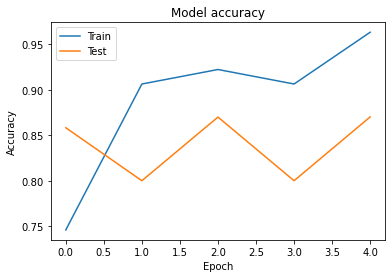

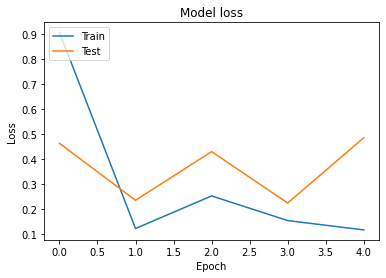

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [23]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [24]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Background_without_leaves',
 5: 'Blueberry___healthy',
 6: 'Cherry___Powdery_mildew',
 7: 'Cherry___healthy',
 8: 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 9: 'Corn___Common_rust',
 10: 'Corn___Northern_Leaf_Blight',
 11: 'Corn___healthy',
 12: 'Grape___Black_rot',
 13: 'Grape___Esca_(Black_Measles)',
 14: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 15: 'Grape___healthy',
 16: 'Orange___Haunglongbing_(Citrus_greening)',
 17: 'Peach___Bacterial_spot',
 18: 'Peach___healthy',
 19: 'Pepper,_bell___Bacterial_spot',
 20: 'Pepper,_bell___healthy',
 21: 'Potato___Early_blight',
 22: 'Potato___Late_blight',
 23: 'Potato___healthy',
 24: 'Raspberry___healthy',
 25: 'Soybean___healthy',
 26: 'Squash___Powdery_mildew',
 27: 'Strawberry___Leaf_scorch',
 28: 'Strawberry___healthy',
 29: 'Tomato___Bacterial_spot',
 30: 'Tomato___Early_blight',
 31: 'Tomato___Late_blight',
 32: 'Toma

In [26]:
import json
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [28]:
from PIL import Image  # Import the Image module from PIL

# Example Usage
image_path = r"C:\Users\ajay\OneDrive\Desktop\capstone\Plant_leave_diseases_dataset_without_augmentation\Grape___Black_rot\image (1).JPG"  # Replace 'path_to_your_new_image.jpg' with the actual path to your image
#image_path = '/content/test_blueberry_healthy.jpg'
#image_path = '/content/test_potato_early_blight.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Predicted Class Name: Grape___Black_rot


In [29]:
model.save('crop_disease_detection_model.h5')